In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Tiền xử lý

In [ ]:
data = pd.read_csv("Modified_SQL_Dataset.csv")

In [ ]:
data.dropna(inplace = True)

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Kết hợp tất cả các bảng đã nêu ở trên
from tqdm import tqdm
preprocessed_query = []
lemmatizer = WordNetLemmatizer()
# tqdm để hiển thị thanh trạng thái
for sentance in tqdm(data['Query'].values):
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = re.sub(r',', ' ', sentance)
    #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    tokenization = nltk.word_tokenize(sentance)
    sentance = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_query.append(sentance.strip())

100%|██████████| 30919/30919 [00:08<00:00, 3728.85it/s]


In [ ]:
preprocessed_query

['pg sleep time',
 'create user name identified pass123 temporary tablespace temp default tablespace user',
 '1 utl inaddr get host address select distinct table name select distinct table name rownum limit sys table limit 5',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 1 union select 1 version 1',
 'select name syscolumns id select id sysobjects name tablename',
 'select user id 1 1 1 1',
 '1 load file char 47 101 116 99 47 112 97 115 115 119 100 1 1 1',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 union select 1 version 1',
 '1 1',
 '',
 'admin 1 1',
 'select user id 1 1 1 1',
 '1 1',
 '1 utl inaddr get host address select distinct column name select distinct column name rownum limit tab column limit 5',
 'select user id 1 union select 1 version 1',
 'select user id 1 1 1 1',
 'select user id 1 1 1 1',
 'distinct',
 'select user id 1 1 1 1',
 '1 ascii lower substring select top 1 name sysobjects xtype u 1 1 116',
 'select user id 1 1 1

In [ ]:
data['Query'] = preprocessed_query
data.head()

,Query,Label
0,pg sleep time,1
1,create user name identified pass123 temporary ...,1
2,1 utl inaddr get host address select distinct ...,1
3,select user id 1 1 1 union select 1 version 1,1
4,select user id 1 1 union select 1 version 1,1


Xuất data

In [ ]:
# data.to_csv("/content/drive/MyDrive/năm 4/an toàn/Train_Dataset.csv")

#Training

## TF-IDF

In [ ]:
X = data.drop(['Label'],axis=1)
y = data['Label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (24735, 1)
X_test shape: (6184, 1)
y_train shape: (24735,)
y_test shape: (6184,)


In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
X_train_tf_idf = tf_idf_vect.fit_transform(X_train['Query'])
X_test_tf_idf = tf_idf_vect.transform(X_test['Query'])

In [ ]:
print(f"X_train shape: {X_train_tf_idf.shape}")
print(f"X_test shape: {X_test_tf_idf.shape}")

X_train shape: (24735, 2706)
X_test shape: (6184, 2706)


In [ ]:
X_train_dense = X_test_tf_idf.todense()
print(f"Cấu trúc tập X_train:")
np.array(X_train_dense[:5, :10])

Cấu trúc tập X_train:


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

You can get the actual words/phrases (1-grams and 2-grams) that correspond to each column in the tf-idf matrix


In [ ]:
features = tf_idf_vect.get_feature_names_out()
features


array(['01', '01 1996', '06', ..., 'zipper', 'zoo', 'zulu'], dtype=object)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_parameters = {'n_neighbors':[1, 3, 5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()

grid = GridSearchCV(estimator = knn, param_grid = knn_parameters , scoring = 'accuracy', verbose = 1,cv=5)
grid.fit(X_train_tf_idf,y_train)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best Score:0.9505963210026278
Best Parameters: {'n_neighbors': 15}


In [ ]:
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_n_neighbors', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
results_summary_sorted

,param_n_neighbors,mean_test_score,std_test_score
14,17,0.950596,0.002510
12,15,0.950596,0.002491
16,19,0.950515,0.002529
10,13,0.950435,0.002615
13,16,0.950435,0.002606
15,18,0.950394,0.002600
17,20,0.950313,0.002593
11,14,0.950071,0.003047
8,11,0.950071,0.002645
9,12,0.949990,0.002934


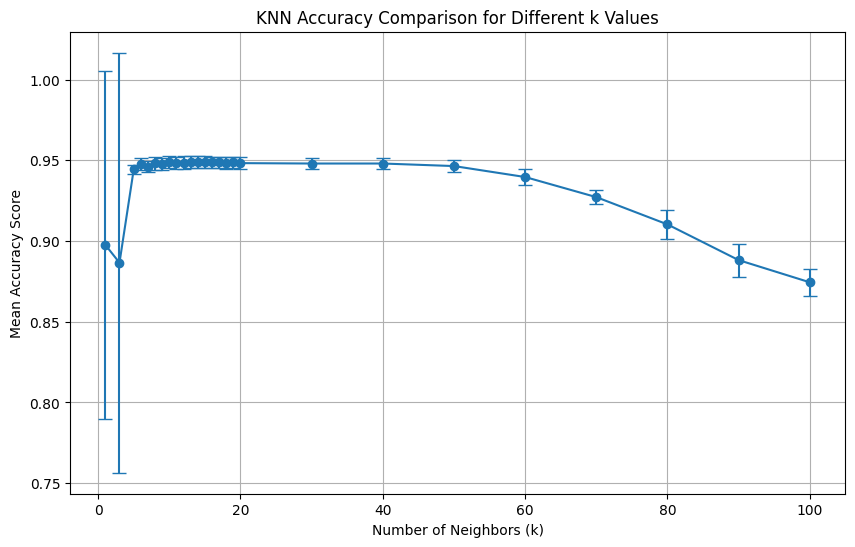

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_summary['param_n_neighbors'], results_summary['mean_test_score'], yerr=results_summary['std_test_score'], fmt='-o', capsize=5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy Score')
plt.title('KNN Accuracy Comparison for Different k Values')
plt.grid(True)
plt.show()

In [ ]:
y_pred = grid.predict(X_test_tf_idf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3908
           1       0.99      0.88      0.93      2276

    accuracy                           0.95      6184
   macro avg       0.96      0.93      0.94      6184
weighted avg       0.95      0.95      0.95      6184



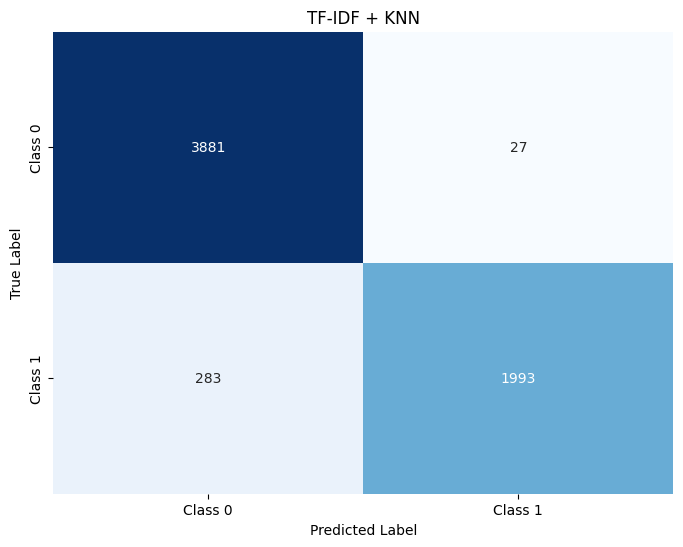

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TF-IDF + KNN')
plt.show()

## XGB

In [ ]:
from xgboost import XGBClassifier

xgb_parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train_tf_idf, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Score: 0.9493834647260966
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
results = pd.DataFrame(grid.cv_results_)
results_summary = results[['param_n_estimators', 'param_max_depth', 'param_learning_rate',
                           'param_subsample', 'param_colsample_bytree', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
results_summary_sorted

,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,mean_test_score,std_test_score
269,200,7,0.20,1.0,0.8,0.949383,0.003070
404,200,7,0.20,1.0,1.0,0.949303,0.002997
403,200,7,0.20,0.8,1.0,0.949303,0.002888
266,150,7,0.20,1.0,0.8,0.949262,0.002957
402,200,7,0.20,0.7,1.0,0.949222,0.002734
...,...,...,...,...,...,...,...
300,10,7,0.01,0.7,1.0,0.631858,0.000081
301,10,7,0.01,0.8,1.0,0.631858,0.000081
302,10,7,0.01,1.0,1.0,0.631858,0.000081
32,10,7,0.01,1.0,0.7,0.631858,0.000081


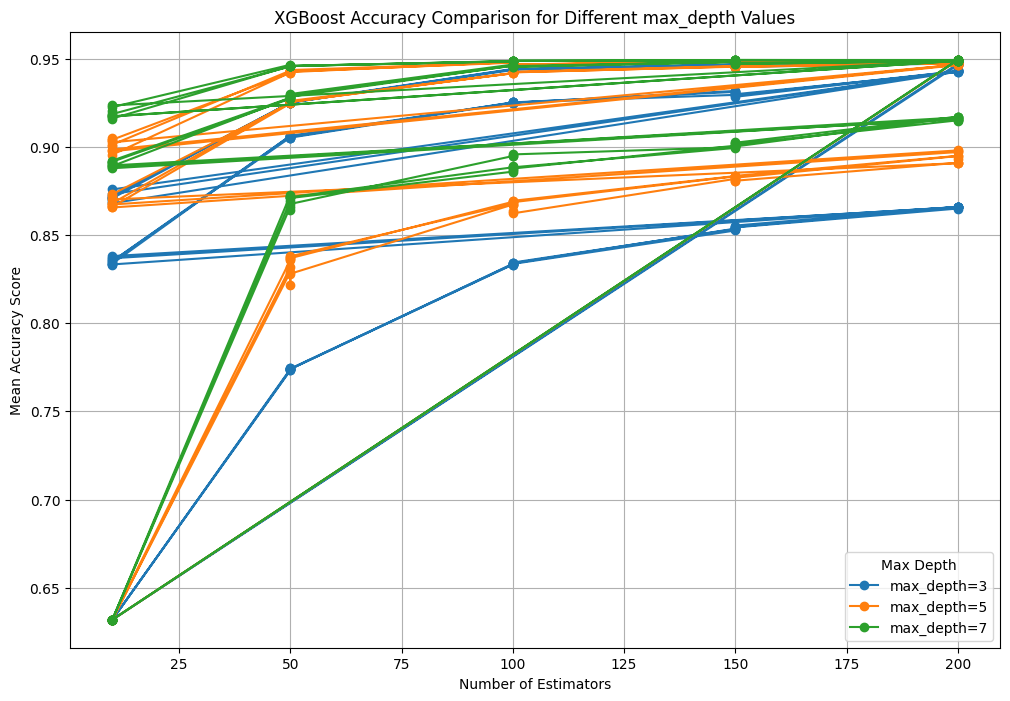

In [ ]:
plt.figure(figsize=(12, 8))
for depth in xgb_parameters['max_depth']:
    subset = results_summary[results_summary['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], '-o', label=f'max_depth={depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('XGBoost Accuracy Comparison for Different max_depth Values')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

In [ ]:
y_pred = grid.predict(X_test_tf_idf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3908
           1       0.99      0.88      0.93      2276

    accuracy                           0.95      6184
   macro avg       0.96      0.94      0.95      6184
weighted avg       0.96      0.95      0.95      6184



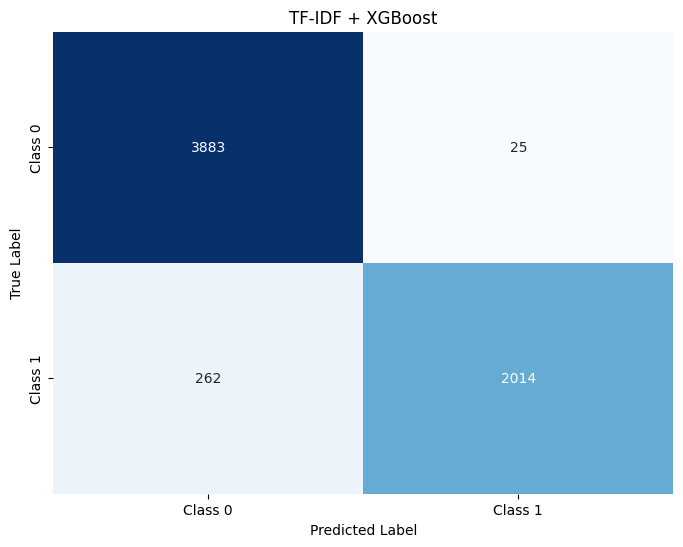

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TF-IDF + XGBoost')
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC

svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
}
svm = SVC()

grid = GridSearchCV(estimator=svm, param_grid=svm_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train_tf_idf, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score: 0.9506771780877299
Best Parameters: {'C': 100, 'kernel': 'rbf'}


In [ ]:
svm_results = pd.DataFrame(grid.cv_results_)
svm_results_summary = svm_results[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score']]
svm_results_summary_sorted = svm_results_summary.sort_values(by='mean_test_score', ascending=False)
svm_results_summary_sorted

,param_C,param_kernel,mean_test_score,std_test_score
10,100.0,rbf,0.950677,0.002385
7,10.0,rbf,0.950637,0.002410
4,1.0,rbf,0.950232,0.002467
8,10.0,poly,0.949747,0.002314
11,100.0,poly,0.949747,0.002314
5,1.0,poly,0.949626,0.002341
6,10.0,linear,0.949586,0.002387
3,1.0,linear,0.948292,0.002658
1,0.1,rbf,0.948211,0.002668
2,0.1,poly,0.947888,0.002245


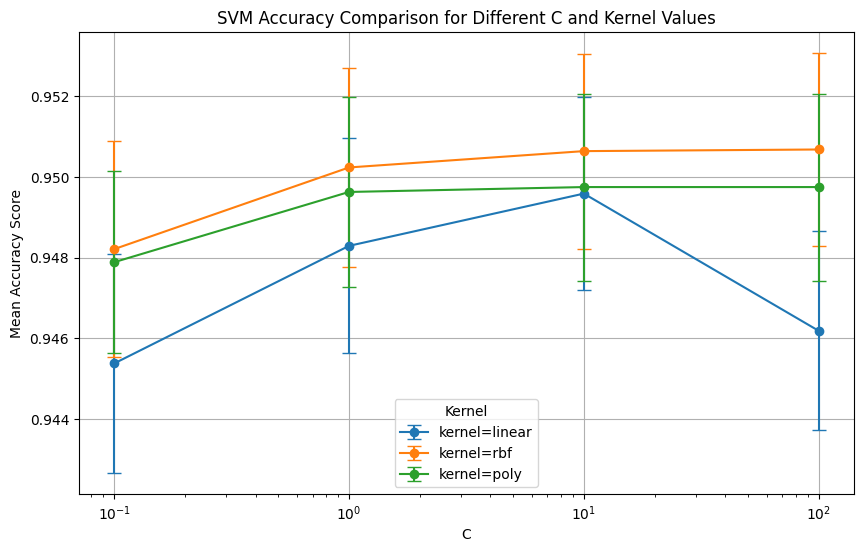

In [ ]:
plt.figure(figsize=(10, 6))
for kernel in ['linear', 'rbf', 'poly']:
    subset = svm_results_summary[svm_results_summary['param_kernel'] == kernel]
    plt.errorbar(subset['param_C'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'kernel={kernel}')
plt.xlabel('C')
plt.ylabel('Mean Accuracy Score')
plt.title('SVM Accuracy Comparison for Different C and Kernel Values')
plt.xscale('log')  # Use logarithmic scale for C to better visualize differences
plt.legend(title='Kernel')
plt.grid(True)
plt.show()

In [ ]:
y_pred = grid.predict(X_test_tf_idf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3908
           1       0.98      0.88      0.93      2276

    accuracy                           0.95      6184
   macro avg       0.96      0.94      0.95      6184
weighted avg       0.95      0.95      0.95      6184



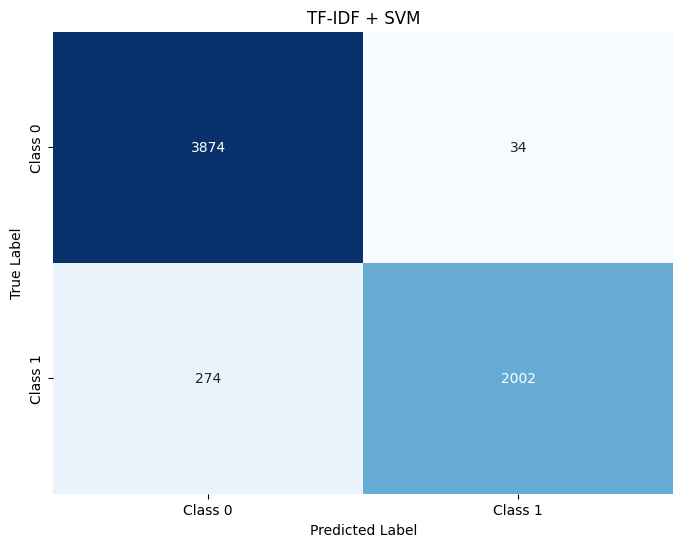

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TF-IDF + SVM')
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}
nb = MultinomialNB()

grid = GridSearchCV(estimator=nb, param_grid=nb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train_tf_idf, y_train)
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.9411360420456842
Best Parameters: {'alpha': 1.0, 'fit_prior': True}


In [ ]:
results_df = pd.DataFrame(grid.cv_results_)
results_summary = results_df[['param_alpha', 'param_fit_prior', 'mean_test_score', 'std_test_score']]
results_summary_sorted = results_summary.sort_values(by='mean_test_score', ascending=False)
results_summary_sorted

,param_alpha,param_fit_prior,mean_test_score,std_test_score
4,1.00,True,0.941136,0.001854
2,0.10,True,0.941055,0.001783
0,0.01,True,0.941015,0.001769
6,10.00,True,0.940408,0.001819
1,0.01,False,0.940125,0.001745
3,0.10,False,0.940044,0.001675
5,1.00,False,0.939842,0.001505
7,10.00,False,0.934991,0.001851


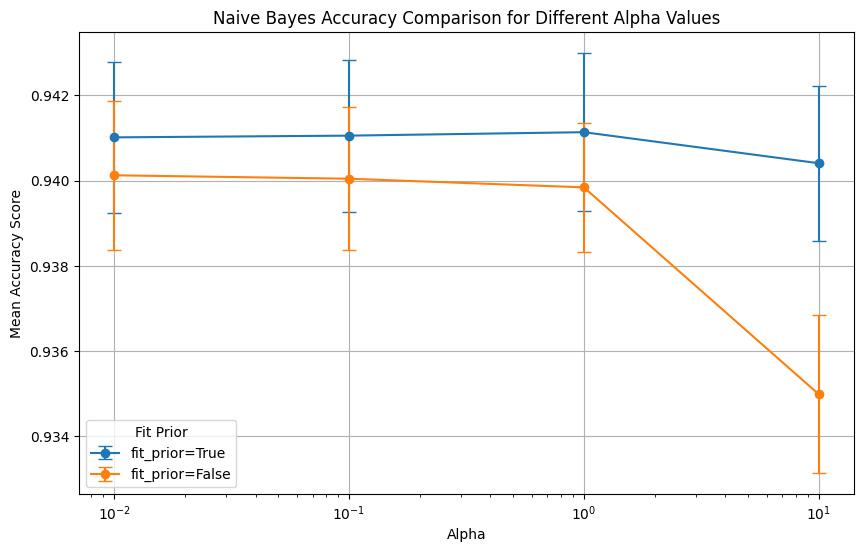

In [ ]:
plt.figure(figsize=(10, 6))
for fit_prior in [True, False]:
    subset = results_summary[results_summary['param_fit_prior'] == fit_prior]
    plt.errorbar(subset['param_alpha'], subset['mean_test_score'], yerr=subset['std_test_score'],
                 fmt='-o', capsize=5, label=f'fit_prior={fit_prior}')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy Score')
plt.title('Naive Bayes Accuracy Comparison for Different Alpha Values')
plt.xscale('log')
plt.legend(title='Fit Prior')
plt.grid(True)
plt.show()

In [ ]:
y_pred = grid.predict(X_test_tf_idf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3908
           1       0.98      0.85      0.91      2276

    accuracy                           0.94      6184
   macro avg       0.95      0.92      0.93      6184
weighted avg       0.94      0.94      0.94      6184



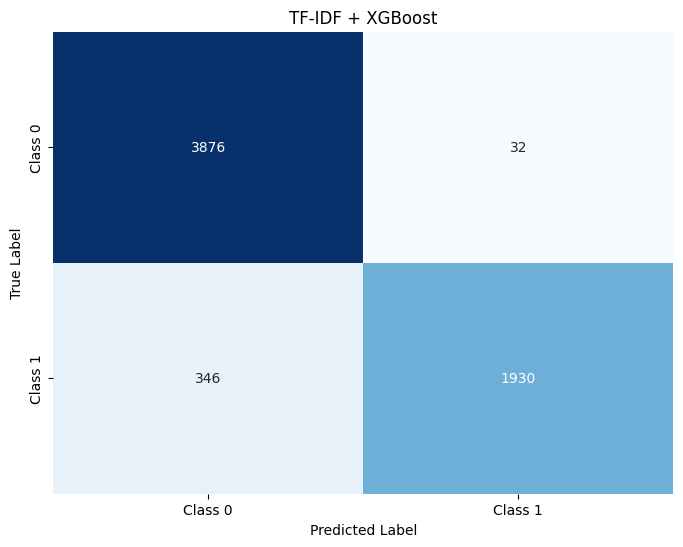

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TF-IDF + XGBoost')
plt.show()